In [6]:
# Import necessary libraries
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda import gpuarray, compiler
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from datetime import datetime
import zipfile
import os

In [7]:
# Helper function to print available CUDA devices
def printGPU():
    """
    Print information about available CUDA devices.
    """
    num_devices = cuda.Device.count()
    print(f"{num_devices} device(s) found.")
    for ordinal in range(num_devices):
        dev = cuda.Device(ordinal)
        print(f"Device #{ordinal}: {dev.name()}")
    print(cuda)

In [8]:
def svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type, theta_start, theta_end):
    """
    Calculate Sky View Factor (SVF) using ray tracing on a GPU.

    Parameters:
        dsm (np.ndarray): Digital Surface Model.
        vegdem (np.ndarray): Vegetation height model.
        vegdem2 (np.ndarray): Vegetation canopy bottom height model.
        scale (float): Scale factor for the height.
        transparency_factor (float): Factor representing the transparency of vegetation.
        svf_type (int): Type of SVF calculation (0: DSM only, 1: Veg, 2: Veg & DSM).
        theta_start (int): Starting angle for theta in degrees.
        theta_end (int): Ending angle for theta in degrees.

    Returns:
        np.ndarray: Calculated Sky View Factor as a 2D array.
    """
    # Convert input arrays to float32
    px = np.array(dsm, dtype=np.float32)
    veg_px = np.array(vegdem, dtype=np.float32)
    veg_px2 = np.array(vegdem2, dtype=np.float32)
    height, width = px.shape

    # Allocate GPU memory
    d_px = gpuarray.to_gpu(px)
    d_veg_px = gpuarray.to_gpu(veg_px)
    d_veg_px2 = gpuarray.to_gpu(veg_px2)
    d_out = gpuarray.empty((height, width), np.float32)

    # CUDA kernel code for SVF calculation
    kernel_code = """
    #include <math.h>
    #define PI 3.141592654

    __global__ void svfcalculator(float *lattice_out, float *lattice, float *veg_lattice, float *veg_lattice2, 
                                   float scale, float transparency_factor, int width, int height, 
                                   int svf_type, int theta_start, int theta_end) {
        int ix = threadIdx.x + blockIdx.x * blockDim.x;
        int iy = threadIdx.y + blockIdx.y * blockDim.y;
        if (ix >= width || iy >= height) return;

        int index = ix + iy * width;
        float clr00 = lattice[index];
        float free_fraction_total = 0.0;

        // Precompute theta values
        float theta[360];
        for (int t = 0; t < 360; ++t) {
            theta[t] = PI * t / 360.0f;
        }

        // Loop over theta in the specified range
        for (int thetaN = theta_start; thetaN < theta_end; thetaN++) {
            float free_fraction = 1.0f;
            bool gamma_stop = false;

            int gamma_steps = 90;
            float gamma_step_inv = 1.0f / float(gamma_steps);

            // Precompute gamma values
            float gamma[91];
            for (int g = 0; g <= gamma_steps; ++g) {
                gamma[g] = (PI / 2.0f) * g * gamma_step_inv;
            }         

            for (int gammaN = 0; gammaN <= gamma_steps; gammaN++) {
                float radius = 1.0f;
                float cos_theta = cosf(theta[thetaN]);
                float sin_theta = sinf(theta[thetaN]); 
                bool crossed_veg = false;          


                while (radius < 450.0f) {
                    int x = ix + int(radius * cos_theta);
                    int y = iy - int(radius * sin_theta);
                    if (x < 0 || x >= width || y < 0 || y >= height) break;
                    int index2 = x + y * width;                    

                    float dsm_height = lattice[index2];
                    float veg_height = veg_lattice[index2];
                    float canopy_bottom_height = veg_lattice2[index2];
                    float ray_height = clr00 + radius * tanf(gamma[gammaN]);                    

                    if (svf_type == 0){
                        if (ray_height < dsm_height){
                            free_fraction -= gamma_step_inv;
                            break;
                        } else if (radius == 449.0){
                            gamma_stop = true;                            
                        } 
                    }
                    if (svf_type == 1){
                        if(ray_height > canopy_bottom_height && ray_height < veg_height){
                            free_fraction -= (transparency_factor * gamma_step_inv);
                            break;
                        } else if (radius == 449.0){
                            gamma_stop = true;
                        }
                    }
                    if (svf_type == 2) {
                        if (ray_height < dsm_height && !crossed_veg) break;
                        else if (ray_height > canopy_bottom_height && ray_height < veg_height) crossed_veg = true;
                        else if (ray_height < dsm_height && crossed_veg){
                            free_fraction -= (transparency_factor * gamma_step_inv);
                            break;
                        }
                        else if (radius == 449.0) gamma_stop = true;
                    }
                    radius += 1.0f;
                }
                if (gamma_stop) break;
            }
            free_fraction_total += free_fraction;
            
        }
        lattice_out[index] = free_fraction_total / float(theta_end - theta_start);
    }
    """

    # Compile the CUDA kernel
    mod = compiler.SourceModule(kernel_code)
    svf_kernel = mod.get_function("svfcalculator")

    # Define block and grid sizes
    block_size = (32, 32, 1)
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))

    # Launch the kernel
    svf_kernel(
        d_out, d_px, d_veg_px, d_veg_px2, np.float32(scale), np.float32(transparency_factor),
        np.int32(width), np.int32(height), np.int32(svf_type),
        np.int32(theta_start), np.int32(theta_end),
        block=block_size, grid=grid_size
    )
    
    # Synchronize the CUDA context
    cuda.Context.synchronize()
    return d_out.get()

In [9]:
# Main function for processing DSM and vegetation data
def main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir):
    """
    Main function to calculate SVF from DSM and vegetation models.

    Parameters:
        dsm_path (str): Path to the DSM raster.
        vegdem_path (str): Path to the vegetation height raster.
        vegdem2_path (str): Path to the vegetation canopy bottom height raster.
        transparency_factor (float): Transparency factor for vegetation.
        output_dir (str): Directory for saving output files.
    """
    # Load DSM and vegetation rasters
    dsm_ds = gdal.Open(dsm_path)
    vegdem_ds = gdal.Open(vegdem_path)
    vegdem2_ds = gdal.Open(vegdem2_path)

    geotransform = dsm_ds.GetGeoTransform()
    scale = 1 / geotransform[1]  # Calculate scale from geotransform

    # Read arrays from raster files
    dsm = dsm_ds.ReadAsArray().astype(np.float32)
    vegdem = vegdem_ds.ReadAsArray().astype(np.float32)
    vegdem2 = vegdem2_ds.ReadAsArray().astype(np.float32)

    # Adjust vegetation heights by adding DSM height
    vegdem = vegdem + dsm
    vegdem2 = vegdem2 + dsm


    # Apply Gaussian filter for smoothing
    vegdem = gaussian_filter(vegdem, sigma=0.5)
    vegdem2 = gaussian_filter(vegdem2, sigma=0.5)

    timestamp = datetime.now().strftime("%H%M%S")
    driver = gdal.GetDriverByName("GTiff")

    # Helper function to save SVF results to GeoTIFF
    def save_svf(filename, svf_data):
        out_ds = driver.Create(
            filename, dsm.shape[1], dsm.shape[0], 1, gdal.GDT_Float32
        )
        out_ds.GetRasterBand(1).WriteArray(svf_data)
        out_ds.SetGeoTransform(dsm_ds.GetGeoTransform())
        out_ds.SetProjection(dsm_ds.GetProjection())
        out_ds.FlushCache()

    # Helper function to plot SVF data
    def plot_svf(svf_data, title):
        plt.figure(figsize=(5, 3))
        plt.imshow(svf_data, cmap="viridis")
        plt.colorbar(label="SVF Value")
        plt.title(title)
        plt.show()

    # Directions for theta range (Wind directions: W, S, E, N)
    directions = {"E": (0, 180), 'S': (90, 270), 'W': (180, 360), 'N': (270, 90)}

    # Prepare a list to hold the file paths for zipping
    file_paths = []

    for direction, (theta_start, theta_end) in directions.items():
        # Calculate different types of SVF
        svf = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 0, theta_start, theta_end)
        svfveg = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 1, theta_start, theta_end)
        svfaveg = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 2, theta_start, theta_end)
        
        # Define file names based on svf_type
        svf_files = [
            (svf, f"{output_dir}/svf{direction}.tif"),              # svf_type == 0  == dsm only
            (svfveg, f"{output_dir}/svf{direction}veg.tif"),        # svf_type == 1  == vegetation only
            (svfaveg, f"{output_dir}/svf{direction}aveg.tif")       # svf_type == 2  == vegetation on buildings
        ]

        # Plot the SVF files
        for svf_data, filename in svf_files:
            plot_svf(svf_data, f"{filename}")
  
        # Save the SVF files and collect the file paths
        for svf_data, filename in svf_files:
            save_svf(filename, svf_data)
            file_paths.append(filename)

    # Zip all the generated files
    zip_filename = f"{output_dir}/svfs_GPU.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in file_paths:
            zipf.write(file, os.path.basename(file))                # Save with only the file name in the zip

    # Close datasets
    dsm_ds = vegdem_ds = vegdem2_ds = None

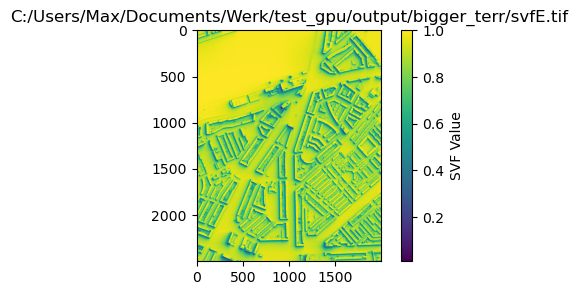

In [10]:
# Run main function
if __name__ == "__main__":
    dsm_path            = "C:/Users/Max/Documents/Werk/test_gpu/input/dsm_buildings_ground_37HN1_14.tif"    # DSM raster file path
    vegdem_path         = "C:/Users/Max/Documents/Werk/test_gpu/input/cdsm_groundlvl_37HN1_14.tif"          # CDSM raster file path
    vegdem2_path        = ("C:/Users/Max/Documents/Werk/test_gpu/input/TDSM.tif")                           # TDSM raster file path
    transparency_factor = 0.97                                                                              # Transparency/opacity factor for vegetation impact
    output_dir          = ("C:/Users/Max/Documents/Werk/test_gpu/output/bigger_terr")                       # Output directory
    gdal.DontUseExceptions()                                                                                # Suppress warnings from GDAL

    main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir)